In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# from train_test_split import train_test_split_hoc
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report


#Language Models Exploration 
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from keras.models import Sequential
from keras.layers import Dense, InputLayer
import tensorflow as tf

In [2]:
# if not os.path.isfile("ssh_attacks_decoded_splitted.parquet"):
#     raise Exception("You should run the preprocessing file")
df = pd.read_parquet("ssh_attacks.parquet")

In [3]:
%run "train_test_split_sampled.ipynb"
df_sampled = sampling(df)

<br><left><b><font size=4>Section 4 – Language Models exploration<b><left>
<div style="text-align: justify">Experiment language models for solving the same supervised task as in Section 2. In this task, the objective is to harness the capabilities of language models like Bert or Word2Vec, for supervised learning (assign intents to sessions). 
<br><br> Two interesting concepts play a role when we use neural networks:
<div style="text-align: justify"><br><b>1)</b> It is possible to do transfer learning, i.e., to take a model that have been trained with other enormous datasets by Big Tech companies, and we can do fine-tuning i.e., to train this model starting from its pre-trained version.
<br><b>2)</b> In NLP tasks, words/documents are transformed into vectors (encoding) and this task is Unsupervised, so we can use a much larger amount of data.
</div><br>
<div style="text-align: justify"><b>4.1. If you choose Doc2Vec: pretrain Doc2Vec on body column of the session text. If you chose Bert: take the pretrained Bert model like in this example. (NB: In this tutorial they used BertForSequenceClassification, but if you want to continue with step 2, you must take an other Bert implementation from HuggingFace)</div><b>
<br><left><b><font size=3> Data Preparation and Cleaning </div></b>
<br><left><b><font size=2> Step 1 </div></b>
The initial phase involved loading the dataset from the 'ssh_attacks.parquet' file. To ensure data quality, a cleaning process was implemented on the 'full_session' column. Non-alphabetic characters were filtered out, and the text was converted to lowercase. This cleaning process was crucial for creating a meaningful representation of the session data.

In this endeavor, we embark on a journey to construct a robust Session Intent Classification model with the overarching goal of assigning intents to sessions using state-of-the-art techniques, specifically leveraging the Doc2Vec model and TensorFlow.

Our odyssey begins with the exploration of a dataset encapsulating session data, with the central task being the classification of intents. We harness the power of the Pandas library to load our dataset from a parquet file, granting us a glimpse into the raw data's structure.


A critical facet of our journey involves preparing the textual data for model ingestion. Employing a function to clean the text, we filter out non-alphabetic characters and convert the text to lowercase, ensuring uniformity and aiding in subsequent analysis.

Subsequently, we embark on the tokenization journey, a crucial step where we convert the cleaned sessions into tagged documents. This allows us to represent our textual data in a format suitable for training the Doc2Vec model.

In [4]:
tagged_data = [TaggedDocument(words=session, tags=[str(session_id)]) for session_id, session in zip(df_sampled["session_id"], df_sampled["full_session"])]

##### Building and Training Doc2Vec Model

<div style="text-align: justify">{Cleaning the text data by removing non-alphabetic characters and converting text to lowercase. The Gensim library was used to train a Doc2Vec model on the cleaned text data. A vocabulary was buildt and the Doc2Vec model was trained to generate the vector of embeddings for each session text.}</div>

Our expedition proceeds with the training of the Doc2Vec model, an unsupervised learning algorithm designed to transform words or documents into numerical vectors. Configuring the model with specific parameters, such as vector size, window size, and epochs, we meticulously craft a representation of the textual data.

In [27]:
'''
if not os.path.isfile("trained_doc2vec_model.model"):
    doc2vec_model = Doc2Vec(tagged_data)
    #doc2vec_model.build_vocab(tagged_data)
    #doc2vec_model.train(tagged_data, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)
    doc2vec_model.save("trained_doc2vec_model.model")
else:
    doc2vec_model = Doc2Vec.load("trained_doc2vec_model.model")
    '''

'\nif not os.path.isfile("trained_doc2vec_model.model"):\n    doc2vec_model = Doc2Vec(tagged_data)\n    #doc2vec_model.build_vocab(tagged_data)\n    #doc2vec_model.train(tagged_data, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)\n    doc2vec_model.save("trained_doc2vec_model.model")\nelse:\n    doc2vec_model = Doc2Vec.load("trained_doc2vec_model.model")\n    '

##### Saving the Trained Model

Our grand architecture unfolds as we transition into building and training the classification model, integrating the pre-trained Doc2Vec embeddings.

We fashion a Sequential model in TensorFlow, introducing a dense layer to accommodate the Doc2Vec embeddings as the input layer. Subsequently, we append a final dense layer, equipped with softmax activation for multiclass classification.

**4.2. Add a last Dense Layer**

<div style="text-align: justify">We have trained the Doc2Vec model, which generated embeddings for our text data. Now, to perform classification, we will build a simple Neural Network that will take these embeddings and will add a dense layer for the classification task. The dense layer will have as many neurons as the number of classes we want to predict.</div>

Created a neural network model using TensorFlow/Keras. Set up the architecture by adding a Dense layer with the input dimension being the size of the Doc2Vec vectors and a final Dense layer with softmax activation for multi-class classification.

In [28]:
'''
%run "train_test_split_sampled.ipynb" 
X = [doc2vec_model.dv[i] for i in range(len(tagged_data))]
y = df_sampled["Set_Fingerprint"]

X_train, X_test, y_train, y_test = split_train_test(X, y, train_size=0.7, random_state=42)
'''

'\n%run "train_test_split_sampled.ipynb" \nX = [doc2vec_model.dv[i] for i in range(len(tagged_data))]\ny = df_sampled["Set_Fingerprint"]\n\nX_train, X_test, y_train, y_test = split_train_test(X, y, train_size=0.7, random_state=42)\n'

In [29]:
'''
mlb = MultiLabelBinarizer()
y_train_mlb = mlb.fit_transform(y_train)
y_test_mlb = mlb.fit_transform(y_test)
'''

'\nmlb = MultiLabelBinarizer()\ny_train_mlb = mlb.fit_transform(y_train)\ny_test_mlb = mlb.fit_transform(y_test)\n'

In [30]:
'''
X_train_tensor = tf.convert_to_tensor(X_train)
X_test_tensor = tf.convert_to_tensor(X_test)
y_train_tensor = tf.convert_to_tensor(y_train_mlb)
y_test_tensor = tf.convert_to_tensor(y_test_mlb)
'''

'\nX_train_tensor = tf.convert_to_tensor(X_train)\nX_test_tensor = tf.convert_to_tensor(X_test)\ny_train_tensor = tf.convert_to_tensor(y_train_mlb)\ny_test_tensor = tf.convert_to_tensor(y_test_mlb)\n'

In [31]:
'''
# create_model function defines a simple neural network model with an input layer and a dense layer. 
def create_model(learning_rate):
    tf.keras.backend.clear_session()
    model = Sequential()
    model.add(InputLayer(input_shape=(doc2vec_model.vector_size,)))
    for _ in range(3):
        model.add(Dense(64, activation='relu'))
    model.add(Dense(7, activation=tf.nn.sigmoid))

    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=tf.keras.losses.BinaryCrossentropy(), 
                  metrics=[tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

    return model

# Hyperparameter combinations
learning_rates = [0.001, 0.01]
epochs = 10

# Create an empty list to store results
results = []

'''

"\n# create_model function defines a simple neural network model with an input layer and a dense layer. \ndef create_model(learning_rate):\n    tf.keras.backend.clear_session()\n    model = Sequential()\n    model.add(InputLayer(input_shape=(doc2vec_model.vector_size,)))\n    for _ in range(3):\n        model.add(Dense(64, activation='relu'))\n    model.add(Dense(7, activation=tf.nn.sigmoid))\n\n    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)\n    model.compile(optimizer=optimizer, loss=tf.keras.losses.BinaryCrossentropy(), \n                  metrics=[tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])\n\n    return model\n\n# Hyperparameter combinations\nlearning_rates = [0.001, 0.01]\nepochs = 10\n\n# Create an empty list to store results\nresults = []\n\n"

In [32]:
'''
for learning_rate in learning_rates:
    model = create_model(learning_rate=learning_rate)
    history = model.fit(X_train_tensor, y_train_tensor, verbose=0, validation_data=(X_test_tensor, y_test_tensor))
    result = {"learning_rate": learning_rate, "metrics": history}
    results.append(result)
    '''

'\nfor learning_rate in learning_rates:\n    model = create_model(learning_rate=learning_rate)\n    history = model.fit(X_train_tensor, y_train_tensor, verbose=0, validation_data=(X_test_tensor, y_test_tensor))\n    result = {"learning_rate": learning_rate, "metrics": history}\n    results.append(result)\n    '

In [33]:
'''
# Numero di subplot per riga
num_cols = 2

# Calcola il numero totale di subplot necessari
num_plots = len(results)

# Calcola il numero di righe necessarie
num_rows = (num_plots + num_cols - 1) // num_cols

# Crea una nuova figura
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))

# Flatten axs se num_rows è 1
if num_rows == 1:
    axs = [axs]

# Ciclo attraverso i risultati e plotta i grafici
for i, result in enumerate(results):
    # Estrai i dati di history
    history = result["metrics"]

    # Calcola la posizione del subplot corrente
    row_idx = i // num_cols
    col_idx = i % num_cols

    # Plot training loss
    axs[row_idx][col_idx].plot(history.history['loss'], label='Training Loss')
    axs[row_idx][col_idx].plot(history.history['val_loss'], label='Validation Loss')
    axs[row_idx][col_idx].set_title(f'Learning Rate: {result["learning_rate"]}')
    axs[row_idx][col_idx].set_xlabel('Epochs')
    axs[row_idx][col_idx].set_ylabel('Loss')
    axs[row_idx][col_idx].legend()

# Mostra il grafico
plt.tight_layout()
plt.show()
'''

'\n# Numero di subplot per riga\nnum_cols = 2\n\n# Calcola il numero totale di subplot necessari\nnum_plots = len(results)\n\n# Calcola il numero di righe necessarie\nnum_rows = (num_plots + num_cols - 1) // num_cols\n\n# Crea una nuova figura\nfig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))\n\n# Flatten axs se num_rows è 1\nif num_rows == 1:\n    axs = [axs]\n\n# Ciclo attraverso i risultati e plotta i grafici\nfor i, result in enumerate(results):\n    # Estrai i dati di history\n    history = result["metrics"]\n\n    # Calcola la posizione del subplot corrente\n    row_idx = i // num_cols\n    col_idx = i % num_cols\n\n    # Plot training loss\n    axs[row_idx][col_idx].plot(history.history[\'loss\'], label=\'Training Loss\')\n    axs[row_idx][col_idx].plot(history.history[\'val_loss\'], label=\'Validation Loss\')\n    axs[row_idx][col_idx].set_title(f\'Learning Rate: {result["learning_rate"]}\')\n    axs[row_idx][col_idx].set_xlabel(\'Epochs\')\n    axs[row_idx

In [34]:
'''def plot_loss(results):
     for i, result in enumerate(results):
        if i >= 3:
            break
        learning_rate = result["learning_rate"]
        history = result["metrics"]
        plt.plot(history.history['loss'], label=f'Training Loss (LR={learning_rate})')
        plt.plot(history.history['val_loss'], label=f'Validation Loss (LR={learning_rate})')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title(f'Loss for Learning Rate: {learning_rate}')
        plt.legend()
        plt.show()'''

'def plot_loss(results):\n     for i, result in enumerate(results):\n        if i >= 3:\n            break\n        learning_rate = result["learning_rate"]\n        history = result["metrics"]\n        plt.plot(history.history[\'loss\'], label=f\'Training Loss (LR={learning_rate})\')\n        plt.plot(history.history[\'val_loss\'], label=f\'Validation Loss (LR={learning_rate})\')\n        plt.xlabel(\'Epochs\')\n        plt.ylabel(\'Loss\')\n        plt.title(f\'Loss for Learning Rate: {learning_rate}\')\n        plt.legend()\n        plt.show()'

In [35]:
'''plot_loss(results)'''

'plot_loss(results)'

In [36]:
'''# Effettua le predizioni delle probabilità sul set di test
y_test_prob = model.predict(X_test_tensor)

# Trova l'etichetta predetta per ogni campione utilizzando una soglia di decisione (ad es. 0.5)
y_test_pred = (y_test_prob >= 0.5).astype(int)

# Calcola il report di classificazione basato solo sulle predizioni
report = classification_report(y_test_pred, y_test_mlb, target_names=mlb.classes_)

# Mostra il report di classificazione
print("Report di classificazione:")
print(report)'''

'# Effettua le predizioni delle probabilità sul set di test\ny_test_prob = model.predict(X_test_tensor)\n\n# Trova l\'etichetta predetta per ogni campione utilizzando una soglia di decisione (ad es. 0.5)\ny_test_pred = (y_test_prob >= 0.5).astype(int)\n\n# Calcola il report di classificazione basato solo sulle predizioni\nreport = classification_report(y_test_pred, y_test_mlb, target_names=mlb.classes_)\n\n# Mostra il report di classificazione\nprint("Report di classificazione:")\nprint(report)'

# VEC SIZE 200


In [37]:
'''
#tagged_data = [TaggedDocument(words=session, tags=[str(session_id)]) for session_id, session in zip(df_sampled["session_id"], df_sampled["full_session"])]

# Crea e addestra il modello Doc2Vec
vector_size = 200
doc2vec_model = Doc2Vec(vector_size=vector_size, epochs=10)
doc2vec_model.build_vocab(tagged_data)
doc2vec_model.train(tagged_data, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)

# Estrai le rappresentazioni vettoriali
X = [doc2vec_model.dv[i] for i in range(len(tagged_data))]
y = df_sampled["Set_Fingerprint"]

# Dividi i dati in training e test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=42)

# Definisci la funzione per creare il modello
def create_model(vector_size, learning_rate):
    model = Sequential()
    model.add(InputLayer(input_shape=(vector_size,)))
    
    # Aggiunta di 25 strati nascosti con 64 unità ciascuno e attivazione ReLU
    for _ in range(3):
        model.add(Dense(64, activation='relu'))
    
    model.add(Dense(7, activation=tf.nn.sigmoid))
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Definisci i learning rate da testare
learning_rates = [0.001, 0.01, 0.1]

# Definisci il numero di epoche
epochs = 10

'''



'\n#tagged_data = [TaggedDocument(words=session, tags=[str(session_id)]) for session_id, session in zip(df_sampled["session_id"], df_sampled["full_session"])]\n\n# Crea e addestra il modello Doc2Vec\nvector_size = 200\ndoc2vec_model = Doc2Vec(vector_size=vector_size, epochs=10)\ndoc2vec_model.build_vocab(tagged_data)\ndoc2vec_model.train(tagged_data, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)\n\n# Estrai le rappresentazioni vettoriali\nX = [doc2vec_model.dv[i] for i in range(len(tagged_data))]\ny = df_sampled["Set_Fingerprint"]\n\n# Dividi i dati in training e test\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=42)\n\n# Definisci la funzione per creare il modello\ndef create_model(vector_size, learning_rate):\n    model = Sequential()\n    model.add(InputLayer(input_shape=(vector_size,)))\n    \n    # Aggiunta di 25 strati nascosti con 64 unità ciascuno e attivazione ReLU\n    for _ in range(3):\n        model.add(Den

# TEST


## overview of the code

### This code defines functions to train a Doc2Vec model, create a neural network model, and train and evaluate the model. It then loops over different combinations of vector sizes and learning rates, training and evaluating a model for each combination. Finally, it prints out the results of each evaluation.

In [39]:
"""# Function to train a Doc2Vec model
def train_doc2vec_model(df_sampled, vector_size=100, epochs=10):
    tagged_data = [TaggedDocument(words=session, tags=[str(session_id)]) for session_id, session in zip(df_sampled["session_id"], df_sampled["full_session"])]
    doc2vec_model = Doc2Vec(vector_size=vector_size, epochs=epochs)
    doc2vec_model.build_vocab(tagged_data)
    doc2vec_model.train(tagged_data, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)
    X = [doc2vec_model.dv[i] for i in range(len(tagged_data))]
    y = df_sampled["Set_Fingerprint"]
    return X, y, doc2vec_model"""

##### train_doc2vec_model: This function is responsible for training a Doc2Vec model. It takes a DataFrame df_sampled, where each row represents a session, along with optional parameters vector_size (default 100) and epochs (default 10). Inside the function: We convert each session into a tagged document format, where the words in the session are associated with a unique tag (session_id). We then initialize a Doc2Vec model with the specified vector_size and epochs, build its vocabulary using the tagged documents, and train the model. Finally, we extract the feature vectors (X) generated by the trained Doc2Vec model and retrieve the corresponding labels (y) from the DataFrame.

In [40]:
"""# Function to create a neural network model
def create_model(vector_size, learning_rate):
    model = Sequential()
    model.add(InputLayer(input_shape=(vector_size,)))
    for _ in range(3):
        model.add(Dense(64, activation='relu'))
    model.add(Dense(7, activation=tf.nn.sigmoid))
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model"""

#### create_model: This function is used to create a neural network model. It takes the vector_size (dimensionality of input vectors) and learning_rate as input. Inside the function: We create a Sequential model, which is a linear stack of layers. We add an input layer with the specified input shape (vector_size). We add three hidden layers with 64 units each and ReLU activation function. We add an output layer with 7 units and sigmoid activation function. We compile the model using the Adam optimizer with the specified learning_rate, binary cross-entropy loss function, and accuracy metric.

In [43]:
"""# Function to train and evaluate the model
def train_and_evaluate(X_train, X_test, y_train, y_test, vector_size, learning_rate, epochs=10):
    model = create_model(vector_size, learning_rate)
    mlb = MultiLabelBinarizer()
    y_train_mlb = mlb.fit_transform(y_train)
    y_test_mlb = mlb.fit_transform(y_test)
    X_train_tensor = tf.convert_to_tensor(X_train)
    X_test_tensor = tf.convert_to_tensor(X_test)
    y_train_tensor = tf.convert_to_tensor(y_train_mlb)
    y_test_tensor = tf.convert_to_tensor(y_test_mlb)
    
    
    print("Training the model (Vector Size: {}, Learning Rate: {})...".format(vector_size, learning_rate))
    history = model.fit(X_train_tensor, y_train_tensor, validation_data=(X_test_tensor, y_test_tensor), epochs=epochs, verbose=0)

    loss_test, accuracy_test = model.evaluate(X_test_tensor, y_test_tensor, verbose=0)
    print("Loss on test set:", loss_test)
    print("Accuracy on test set:", accuracy_test)
    
    plt.plot(history.history['loss'], label=f'Training Loss (LR={learning_rate})')
    plt.plot(history.history['val_loss'], label=f'Validation Loss (LR={learning_rate})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss (Vector Size: {})'.format(vector_size))
    plt.legend()
    plt.show()
    
    # Classification report for test set
    y_test_prob = model.predict(X_test_tensor)
    y_test_pred = (y_test_prob >= 0.5).astype(int)
    report_test = classification_report(y_test_pred, y_test_mlb, target_names=mlb.classes_)
    print("Classification Report (Vector Size: {}):".format(vector_size))
    print(report_test)

    # Classification report for train set
    y_train_prob = model.predict(X_train_tensor)
    y_train_pred = (y_train_prob >= 0.5).astype(int)
    report_train = classification_report(y_train_pred, y_train_mlb, target_names=mlb.classes_)
    print("Classification Report on Train Set (Vector Size: {}):".format(vector_size))
    print(report_train)

"""
    

##### train_and_evaluate: This function is responsible for training and evaluating the neural network model. It takes the training and test data (X_train, X_test, y_train, y_test), along with vector_size, learning_rate, and optional epochs as input. Inside the function: We create the model using create_model. We convert the multi-label target variables into a binary form using MultiLabelBinarizer. We convert the input data into TensorFlow tensors. We train the model on the training data and validate it on the test data, recording the training history. We evaluate the trained model on the test data, calculating the loss and accuracy. We plot the training and validation loss curves. We make predictions on the test data and generate a classification report.

In [42]:
"""
# List of vector sizes and learning rates
vector_sizes = [100, 300, 800]
learning_rates = [0.001, 0.01, 0.1]
train_size = 0.7
random_state = 42
epochs = 10"""

Training the model (Vector Size: 100, Learning Rate: 0.001)...
Loss on test set: 0.05298539623618126
Accuracy on test set: 0.6224373579025269


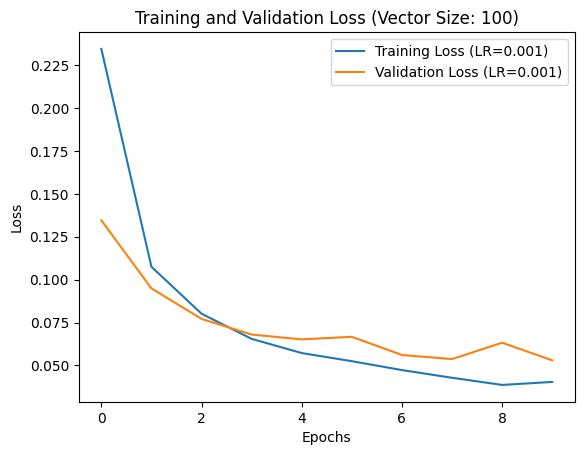

55/55 [==============================] - 0s 2ms/step
Classification Report (Vector Size: 100):
                 precision    recall  f1-score   support

Defense Evasion       0.76      0.92      0.83       117
      Discovery       1.00      1.00      1.00      1751
      Execution       0.92      0.92      0.92       699
       Harmless       0.14      0.60      0.23         5
         Impact       0.20      1.00      0.33         1
          Other       0.40      0.67      0.50         3
    Persistence       1.00      0.98      0.99      1613

      micro avg       0.97      0.98      0.97      4189
      macro avg       0.63      0.87      0.69      4189
   weighted avg       0.98      0.98      0.98      4189
    samples avg       0.97      0.98      0.97      4189

 59/129 [============>.................] - ETA: 0s

C:\Users\Alessio_loc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


129/129 [==============================] - 0s 2ms/step
Classification Report on Train Set (Vector Size: 100):
                 precision    recall  f1-score   support

Defense Evasion       0.85      0.95      0.90       300
      Discovery       1.00      1.00      1.00      4086
      Execution       0.95      0.95      0.95      1645
       Harmless       0.25      0.92      0.39        13
         Impact       0.00      0.00      0.00         0
          Other       0.75      1.00      0.86         9
    Persistence       1.00      0.99      0.99      3742

      micro avg       0.98      0.98      0.98      9795
      macro avg       0.69      0.83      0.73      9795
   weighted avg       0.99      0.98      0.98      9795
    samples avg       0.98      0.98      0.98      9795



C:\Users\Alessio_loc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alessio_loc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training the model (Vector Size: 100, Learning Rate: 0.01)...
Loss on test set: 0.04360595718026161
Accuracy on test set: 0.8872437477111816


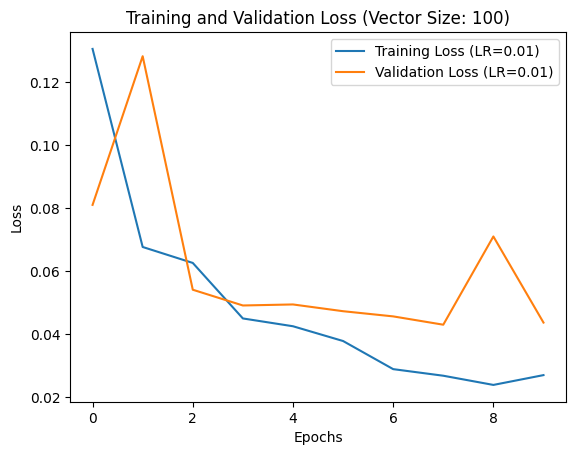

55/55 [==============================] - 0s 2ms/step
Classification Report (Vector Size: 100):
                 precision    recall  f1-score   support

Defense Evasion       0.85      0.93      0.89       130
      Discovery       1.00      1.00      1.00      1743
      Execution       0.91      0.95      0.93       671
       Harmless       0.52      0.85      0.65        13
         Impact       0.20      0.50      0.29         2
          Other       0.60      0.75      0.67         4
    Persistence       1.00      0.98      0.99      1608

      micro avg       0.97      0.98      0.98      4171
      macro avg       0.73      0.85      0.77      4171
   weighted avg       0.98      0.98      0.98      4171
    samples avg       0.97      0.98      0.98      4171

 51/129 [==========>...................] - ETA: 0s

C:\Users\Alessio_loc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


129/129 [==============================] - 0s 2ms/step
Classification Report on Train Set (Vector Size: 100):
                 precision    recall  f1-score   support

Defense Evasion       0.93      0.97      0.95       321
      Discovery       1.00      1.00      1.00      4068
      Execution       0.95      0.98      0.97      1588
       Harmless       0.65      0.78      0.70        40
         Impact       0.22      1.00      0.36         2
          Other       0.83      1.00      0.91        10
    Persistence       1.00      0.99      1.00      3726

      micro avg       0.99      0.99      0.99      9755
      macro avg       0.80      0.96      0.84      9755
   weighted avg       0.99      0.99      0.99      9755
    samples avg       0.99      0.99      0.99      9755

Training the model (Vector Size: 100, Learning Rate: 0.1)...


C:\Users\Alessio_loc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Loss on test set: 0.09538384526968002
Accuracy on test set: 0.9128701686859131


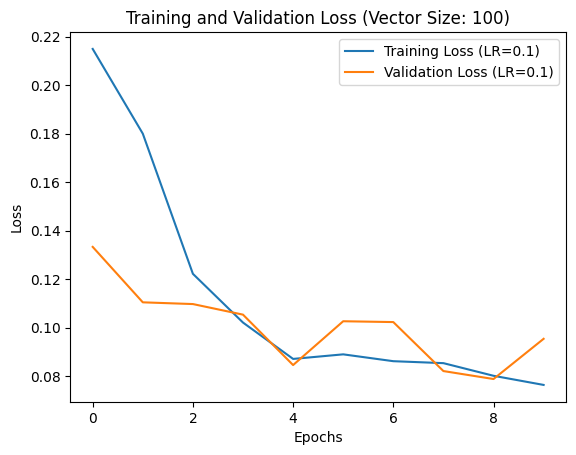

55/55 [==============================] - 0s 2ms/step
Classification Report (Vector Size: 100):
                 precision    recall  f1-score   support

Defense Evasion       0.89      0.71      0.79       178
      Discovery       1.00      0.99      1.00      1756
      Execution       0.95      0.78      0.86       851
       Harmless       0.00      0.00      0.00         0
         Impact       0.00      0.00      0.00         0
          Other       0.00      0.00      0.00         0
    Persistence       0.98      0.98      0.98      1580

      micro avg       0.97      0.94      0.96      4365
      macro avg       0.55      0.50      0.52      4365
   weighted avg       0.98      0.94      0.96      4365
    samples avg       0.97      0.94      0.95      4365

 67/129 [==============>...............] - ETA: 0s

C:\Users\Alessio_loc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


129/129 [==============================] - 0s 2ms/step
Classification Report on Train Set (Vector Size: 100):
                 precision    recall  f1-score   support

Defense Evasion       0.90      0.70      0.78       433
      Discovery       1.00      0.99      1.00      4097
      Execution       0.96      0.79      0.87      1984
       Harmless       0.00      0.00      0.00         0
         Impact       0.00      0.00      0.00         0
          Other       0.00      0.00      0.00         0
    Persistence       0.98      0.99      0.98      3664

      micro avg       0.97      0.94      0.96     10178
      macro avg       0.55      0.50      0.52     10178
   weighted avg       0.98      0.94      0.96     10178
    samples avg       0.97      0.94      0.95     10178



C:\Users\Alessio_loc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training the model (Vector Size: 300, Learning Rate: 0.001)...
Loss on test set: 0.046053580939769745
Accuracy on test set: 0.8952164053916931


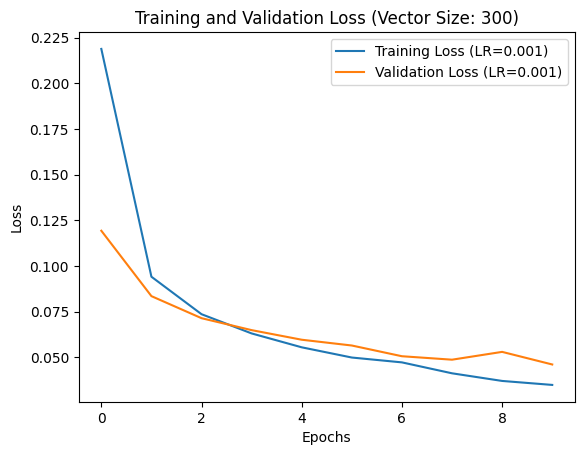

55/55 [==============================] - 0s 2ms/step
Classification Report (Vector Size: 300):
                 precision    recall  f1-score   support

Defense Evasion       0.94      0.83      0.88       162
      Discovery       1.00      0.99      1.00      1752
      Execution       0.95      0.91      0.93       739
       Harmless       0.14      0.75      0.24         4
         Impact       0.40      1.00      0.57         2
          Other       0.40      0.67      0.50         3
    Persistence       0.99      0.99      0.99      1580

      micro avg       0.98      0.97      0.98      4242
      macro avg       0.69      0.88      0.73      4242
   weighted avg       0.98      0.97      0.98      4242
    samples avg       0.98      0.97      0.97      4242

129/129 [==============================] - 0s 2ms/step
Classification Report on Train Set (Vector Size: 300):
                 precision    recall  f1-score   support

Defense Evasion       0.98      0.87      0.92    

C:\Users\Alessio_loc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training the model (Vector Size: 300, Learning Rate: 0.01)...
Loss on test set: 0.044107042253017426
Accuracy on test set: 0.912300705909729


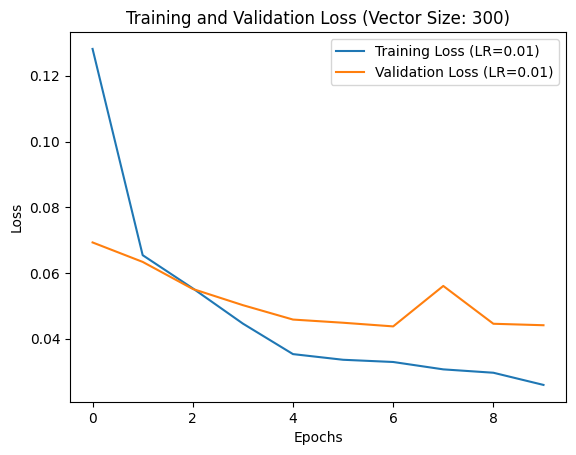

55/55 [==============================] - 0s 2ms/step
Classification Report (Vector Size: 300):
                 precision    recall  f1-score   support

Defense Evasion       0.87      0.90      0.89       139
      Discovery       1.00      1.00      1.00      1747
      Execution       0.95      0.93      0.94       711
       Harmless       0.29      0.86      0.43         7
         Impact       0.00      0.00      0.00         0
          Other       0.60      0.75      0.67         4
    Persistence       0.99      0.99      0.99      1582

      micro avg       0.98      0.98      0.98      4190
      macro avg       0.67      0.78      0.70      4190
   weighted avg       0.98      0.98      0.98      4190
    samples avg       0.98      0.98      0.98      4190

 55/129 [===========>..................] - ETA: 0s

C:\Users\Alessio_loc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alessio_loc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


129/129 [==============================] - 0s 2ms/step
Classification Report on Train Set (Vector Size: 300):
                 precision    recall  f1-score   support

Defense Evasion       0.98      0.93      0.95       350
      Discovery       1.00      1.00      1.00      4074
      Execution       0.98      0.96      0.97      1670
       Harmless       0.71      0.83      0.76        41
         Impact       0.00      0.00      0.00         0
          Other       0.83      0.91      0.87        11
    Persistence       1.00      1.00      1.00      3706

      micro avg       0.99      0.99      0.99      9852
      macro avg       0.79      0.80      0.79      9852
   weighted avg       0.99      0.99      0.99      9852
    samples avg       0.99      0.99      0.99      9852



C:\Users\Alessio_loc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Alessio_loc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training the model (Vector Size: 300, Learning Rate: 0.1)...
Loss on test set: 0.0905022844672203
Accuracy on test set: 0.9128701686859131


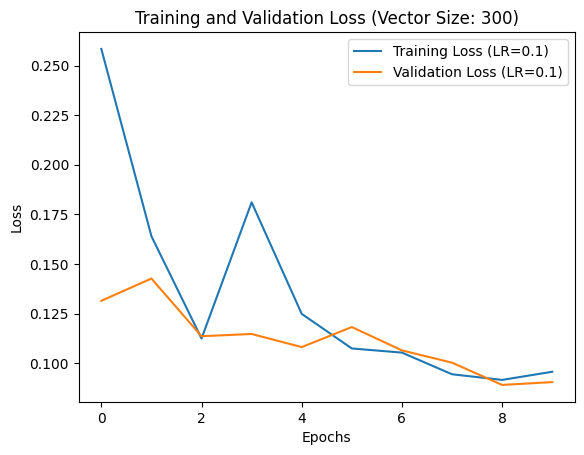

55/55 [==============================] - 0s 2ms/step
Classification Report (Vector Size: 300):
                 precision    recall  f1-score   support

Defense Evasion       0.00      0.00      0.00         0
      Discovery       1.00      0.99      1.00      1756
      Execution       0.79      0.96      0.87       580
       Harmless       0.00      0.00      0.00         0
         Impact       0.00      0.00      0.00         0
          Other       0.00      0.00      0.00         0
    Persistence       1.00      0.90      0.95      1756

      micro avg       0.92      0.95      0.94      4092
      macro avg       0.40      0.41      0.40      4092
   weighted avg       0.97      0.95      0.96      4092
    samples avg       0.92      0.94      0.93      4092

 55/129 [===========>..................] - ETA: 0s

C:\Users\Alessio_loc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


129/129 [==============================] - 0s 2ms/step
Classification Report on Train Set (Vector Size: 300):
                 precision    recall  f1-score   support

Defense Evasion       0.00      0.00      0.00         0
      Discovery       1.00      0.99      1.00      4097
      Execution       0.79      0.96      0.87      1344
       Harmless       0.00      0.00      0.00         0
         Impact       0.00      0.00      0.00         0
          Other       0.00      0.00      0.00         0
    Persistence       1.00      0.90      0.95      4097

      micro avg       0.92      0.95      0.94      9538
      macro avg       0.40      0.41      0.40      9538
   weighted avg       0.97      0.95      0.96      9538
    samples avg       0.92      0.94      0.93      9538



C:\Users\Alessio_loc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training the model (Vector Size: 800, Learning Rate: 0.001)...
Loss on test set: 0.042647793889045715
Accuracy on test set: 0.3587699234485626


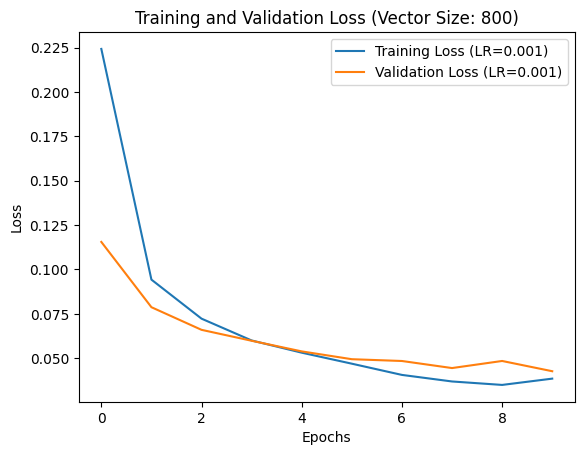

55/55 [==============================] - 0s 2ms/step
Classification Report (Vector Size: 800):
                 precision    recall  f1-score   support

Defense Evasion       0.89      0.91      0.90       140
      Discovery       1.00      1.00      1.00      1748
      Execution       0.94      0.93      0.94       702
       Harmless       0.24      0.56      0.33         9
         Impact       0.40      1.00      0.57         2
          Other       0.40      0.67      0.50         3
    Persistence       0.99      0.99      0.99      1591

      micro avg       0.98      0.98      0.98      4195
      macro avg       0.69      0.86      0.75      4195
   weighted avg       0.98      0.98      0.98      4195
    samples avg       0.98      0.98      0.97      4195

 47/129 [=========>....................] - ETA: 0s

C:\Users\Alessio_loc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


129/129 [==============================] - 0s 2ms/step
Classification Report on Train Set (Vector Size: 800):
                 precision    recall  f1-score   support

Defense Evasion       0.95      0.92      0.93       345
      Discovery       1.00      1.00      1.00      4075
      Execution       0.96      0.95      0.96      1648
       Harmless       0.27      0.93      0.42        14
         Impact       0.56      1.00      0.71         5
          Other       0.83      1.00      0.91        10
    Persistence       1.00      1.00      1.00      3705

      micro avg       0.99      0.99      0.99      9802
      macro avg       0.79      0.97      0.85      9802
   weighted avg       0.99      0.99      0.99      9802
    samples avg       0.99      0.99      0.98      9802



C:\Users\Alessio_loc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training the model (Vector Size: 800, Learning Rate: 0.01)...
Loss on test set: 0.042719148099422455
Accuracy on test set: 0.4948747158050537


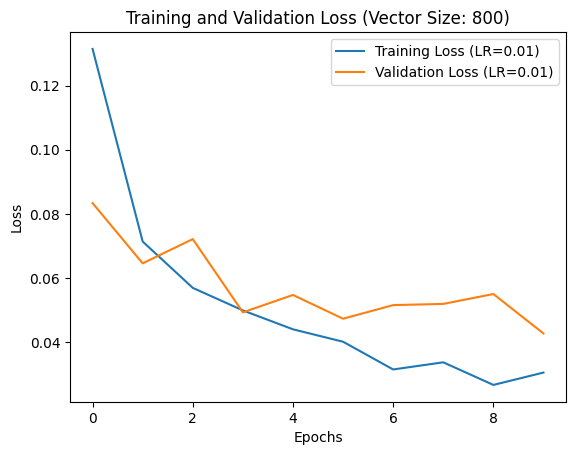

55/55 [==============================] - 0s 3ms/step
Classification Report (Vector Size: 800):
                 precision    recall  f1-score   support

Defense Evasion       0.94      0.88      0.91       152
      Discovery       1.00      1.00      1.00      1749
      Execution       0.94      0.93      0.93       713
       Harmless       0.52      0.69      0.59        16
         Impact       0.20      1.00      0.33         1
          Other       0.20      0.50      0.29         2
    Persistence       0.99      0.99      0.99      1584

      micro avg       0.98      0.98      0.98      4217
      macro avg       0.68      0.85      0.72      4217
   weighted avg       0.98      0.98      0.98      4217
    samples avg       0.98      0.98      0.98      4217

 49/129 [==========>...................] - ETA: 0s

C:\Users\Alessio_loc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


129/129 [==============================] - 0s 2ms/step
Classification Report on Train Set (Vector Size: 800):
                 precision    recall  f1-score   support

Defense Evasion       0.97      0.95      0.96       341
      Discovery       1.00      1.00      1.00      4071
      Execution       0.98      0.96      0.97      1667
       Harmless       0.62      0.88      0.73        34
         Impact       0.11      1.00      0.20         1
          Other       0.58      1.00      0.74         7
    Persistence       0.99      1.00      1.00      3694

      micro avg       0.99      0.99      0.99      9815
      macro avg       0.75      0.97      0.80      9815
   weighted avg       0.99      0.99      0.99      9815
    samples avg       0.99      0.99      0.99      9815



C:\Users\Alessio_loc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training the model (Vector Size: 800, Learning Rate: 0.1)...
Loss on test set: 0.15482540428638458
Accuracy on test set: 0.9117311835289001


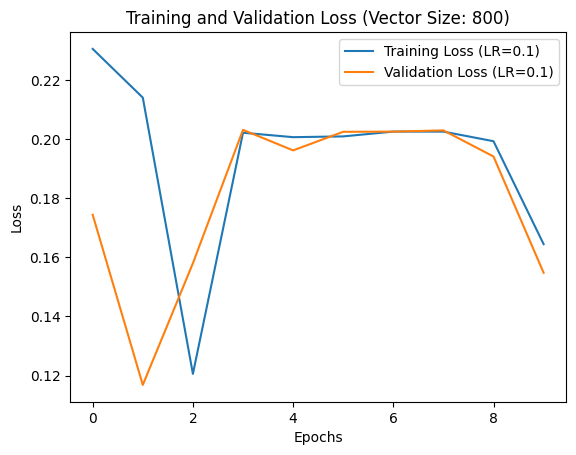

55/55 [==============================] - 0s 3ms/step
Classification Report (Vector Size: 800):
                 precision    recall  f1-score   support

Defense Evasion       0.00      0.00      0.00         0
      Discovery       1.00      0.99      1.00      1756
      Execution       0.87      0.62      0.73       983
       Harmless       0.00      0.00      0.00         0
         Impact       0.00      0.00      0.00         0
          Other       0.00      0.00      0.00         0
    Persistence       1.00      0.90      0.95      1756

      micro avg       0.94      0.88      0.91      4495
      macro avg       0.41      0.36      0.38      4495
   weighted avg       0.97      0.88      0.92      4495
    samples avg       0.93      0.88      0.90      4495

 20/129 [===>..........................] - ETA: 0s

C:\Users\Alessio_loc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


129/129 [==============================] - 0s 3ms/step
Classification Report on Train Set (Vector Size: 800):
                 precision    recall  f1-score   support

Defense Evasion       0.00      0.00      0.00         0
      Discovery       1.00      0.99      1.00      4097
      Execution       0.86      0.62      0.72      2268
       Harmless       0.00      0.00      0.00         0
         Impact       0.00      0.00      0.00         0
          Other       0.00      0.00      0.00         0
    Persistence       1.00      0.90      0.95      4097

      micro avg       0.93      0.88      0.91     10462
      macro avg       0.41      0.36      0.38     10462
   weighted avg       0.97      0.88      0.92     10462
    samples avg       0.93      0.88      0.90     10462



C:\Users\Alessio_loc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [44]:
"""# Loop over each vector size
for vector_size in vector_sizes:
    X, y, doc2vec_model = train_doc2vec_model(df_sampled, vector_size)
    X_train, X_test, y_train, y_test = split_train_test(X, y, train_size=train_size, random_state=random_state)

    # Loop over each learning rate
    for learning_rate in learning_rates:
        train_and_evaluate(X_train, X_test, y_train, y_test, vector_size, learning_rate, epochs)
"""

# FINE EXTRA

In [5]:
# Function to train a Doc2Vec model
def train_doc2vec_model(df_sampled, vector_size=100, epochs=10):
    tagged_data = [TaggedDocument(words=session, tags=[str(session_id)]) for session_id, session in zip(df_sampled["session_id"], df_sampled["full_session"])]
    doc2vec_model = Doc2Vec(vector_size=vector_size, epochs=epochs, seed=42)
    doc2vec_model.build_vocab(tagged_data)
    doc2vec_model.train(tagged_data, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)
    X = [doc2vec_model.dv[i] for i in range(len(tagged_data))]
    y = df_sampled["Set_Fingerprint"]
    return X, y, doc2vec_model

In [6]:
# Function to create a neural network model
def create_model(vector_size, learning_rate):
    model = Sequential()
    model.add(InputLayer(input_shape=(vector_size,)))
    for _ in range(3):
        model.add(Dense(64, activation='relu'))
    model.add(Dense(7, activation=tf.nn.sigmoid))
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [14]:
# Function to train and evaluate the model
def train_and_evaluate(X_train, X_test, y_train, y_test, vector_size, learning_rate, epochs=10):
    model = create_model(vector_size, learning_rate)
    mlb = MultiLabelBinarizer()
    y_train_mlb = mlb.fit_transform(y_train)
    y_test_mlb = mlb.transform(y_test)  # Use transform instead of fit_transform to maintain consistency
    X_train_tensor = tf.convert_to_tensor(X_train)
    X_test_tensor = tf.convert_to_tensor(X_test)
    y_train_tensor = tf.convert_to_tensor(y_train_mlb)
    y_test_tensor = tf.convert_to_tensor(y_test_mlb)
    
    print("Training the model (Vector Size: {}, Learning Rate: {})...".format(vector_size, learning_rate))
    history = model.fit(X_train_tensor, y_train_tensor, validation_data=(X_test_tensor, y_test_tensor), epochs=epochs, verbose=0)

    loss_test, accuracy_test = model.evaluate(X_test_tensor, y_test_tensor, verbose=0)
    print("Loss on test set:", loss_test)
    print("Accuracy on test set:", accuracy_test)
    
    plt.plot(history.history['loss'], label=f'Training Loss (LR={learning_rate})')
    plt.plot(history.history['val_loss'], label=f'Validation Loss (LR={learning_rate})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss (Vector Size: {})'.format(vector_size))
    plt.legend()
    plt.show()
    
    # Classification report for test set
    y_test_prob = model.predict(X_test_tensor)
    y_test_pred = (y_test_prob >= 0.5).astype(int)
    report_test = classification_report(y_test_mlb, y_test_pred, target_names=mlb.classes_, zero_division=1)
    print("Classification Report (Vector Size: {}):".format(vector_size))
    print(report_test)

    # Classification report for train set
    y_train_prob = model.predict(X_train_tensor)
    y_train_pred = (y_train_prob >= 0.5).astype(int)
    report_train = classification_report(y_train_mlb, y_train_pred, target_names=mlb.classes_, zero_division=1)
    print("Classification Report on Train Set (Vector Size: {}):".format(vector_size))
    print(report_train)


In [13]:

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# List of vector sizes and learning rates
vector_sizes = [100, 300, 800]
learning_rates = [0.001, 0.01, 0.1]
train_size = 0.7
random_state = 42
epochs = 10

In [16]:
# Instruct Jupyter to display all output without truncation
from IPython.display import display, HTML

display(HTML("<style>.output_area pre { white-space: pre-wrap; }</style>"))

Training the model (Vector Size: 100, Learning Rate: 0.001)...
Loss on test set: 0.04554375633597374
Accuracy on test set: 0.873576283454895


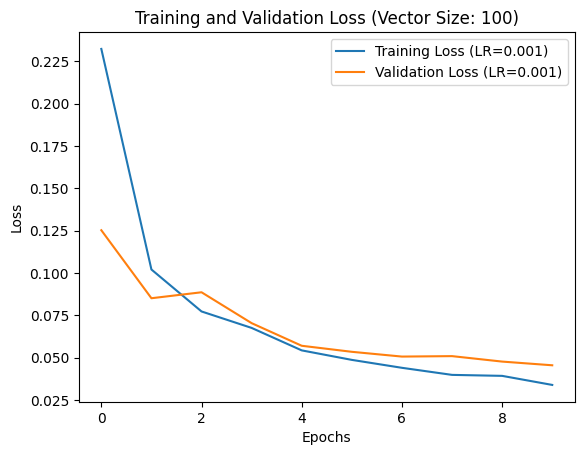

55/55 [==============================] - 0s 2ms/step
Classification Report (Vector Size: 100):
                 precision    recall  f1-score   support

Defense Evasion       0.89      0.88      0.89       143
      Discovery       1.00      1.00      1.00      1745
      Execution       0.94      0.91      0.92       701
       Harmless       0.50      0.14      0.22        21
         Impact       0.00      0.00      1.00         5
          Other       1.00      0.40      0.57         5
    Persistence       0.99      0.99      0.99      1586

      micro avg       0.98      0.97      0.98      4206
      macro avg       0.76      0.62      0.80      4206
   weighted avg       0.98      0.97      0.97      4206
    samples avg       0.98      0.97      0.97      4206

129/129 [==============================] - 0s 2ms/step
Classification Report on Train Set (Vector Size: 100):
                 precision    recall  f1-score   support

Defense Evasion       0.90      0.93      0.91    

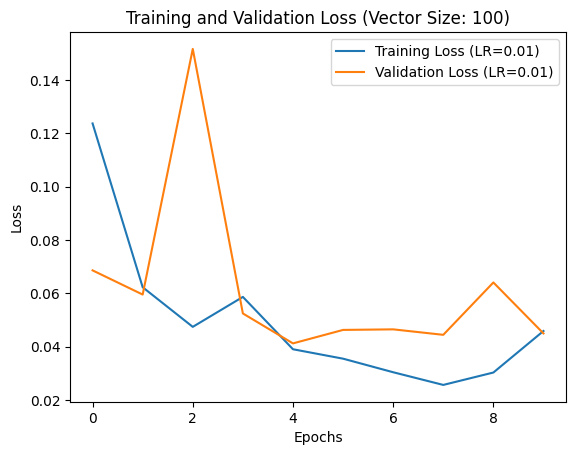

55/55 [==============================] - 0s 2ms/step
Classification Report (Vector Size: 100):
                 precision    recall  f1-score   support

Defense Evasion       0.85      0.85      0.85       143
      Discovery       1.00      1.00      1.00      1745
      Execution       0.92      0.93      0.92       701
       Harmless       0.56      0.43      0.49        21
         Impact       1.00      0.20      0.33         5
          Other       1.00      0.00      0.00         5
    Persistence       0.99      0.99      0.99      1586

      micro avg       0.98      0.97      0.98      4206
      macro avg       0.90      0.63      0.65      4206
   weighted avg       0.98      0.97      0.97      4206
    samples avg       0.98      0.97      0.97      4206

129/129 [==============================] - 0s 2ms/step
Classification Report on Train Set (Vector Size: 100):
                 precision    recall  f1-score   support

Defense Evasion       0.95      0.94      0.94    

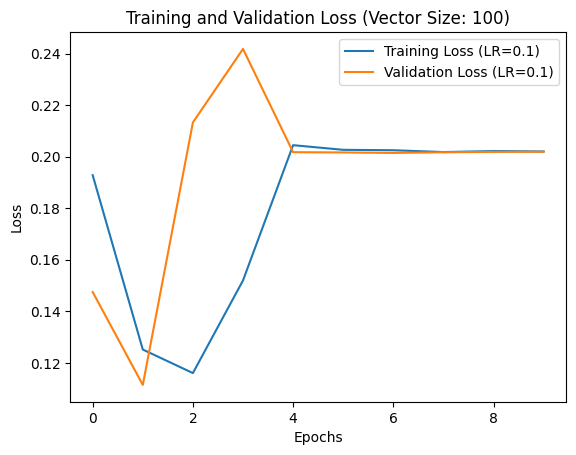

55/55 [==============================] - 0s 2ms/step
Classification Report (Vector Size: 100):
                 precision    recall  f1-score   support

Defense Evasion       1.00      0.00      0.00       143
      Discovery       0.99      1.00      1.00      1745
      Execution       1.00      0.01      0.02       701
       Harmless       1.00      0.00      0.00        21
         Impact       1.00      0.00      0.00         5
          Other       1.00      0.00      0.00         5
    Persistence       0.90      1.00      0.95      1586

      micro avg       0.95      0.79      0.86      4206
      macro avg       0.99      0.29      0.28      4206
   weighted avg       0.96      0.79      0.78      4206
    samples avg       0.95      0.82      0.88      4206

129/129 [==============================] - 0s 2ms/step
Classification Report on Train Set (Vector Size: 100):
                 precision    recall  f1-score   support

Defense Evasion       1.00      0.00      0.00    

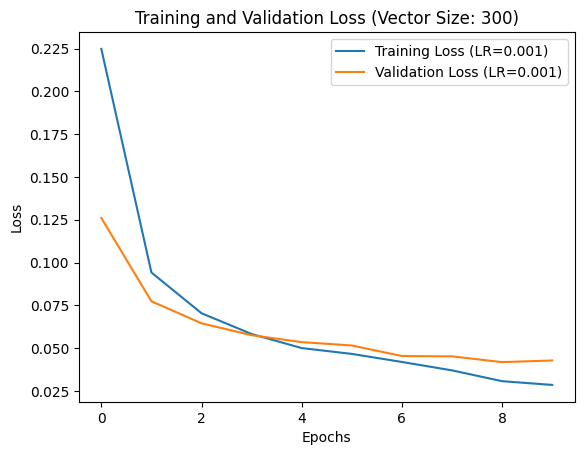

55/55 [==============================] - 0s 2ms/step
Classification Report (Vector Size: 300):
                 precision    recall  f1-score   support

Defense Evasion       0.93      0.87      0.90       143
      Discovery       1.00      1.00      1.00      1745
      Execution       0.89      0.95      0.92       701
       Harmless       0.46      0.29      0.35        21
         Impact       1.00      0.20      0.33         5
          Other       1.00      0.60      0.75         5
    Persistence       0.99      0.99      0.99      1586

      micro avg       0.97      0.98      0.98      4206
      macro avg       0.89      0.70      0.75      4206
   weighted avg       0.97      0.98      0.97      4206
    samples avg       0.97      0.98      0.97      4206

129/129 [==============================] - 0s 1ms/step
Classification Report on Train Set (Vector Size: 300):
                 precision    recall  f1-score   support

Defense Evasion       0.94      0.96      0.95    

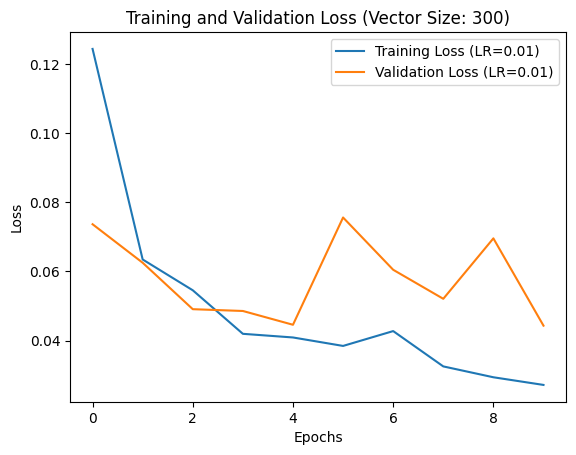

55/55 [==============================] - 0s 2ms/step
Classification Report (Vector Size: 300):
                 precision    recall  f1-score   support

Defense Evasion       0.97      0.88      0.92       143
      Discovery       1.00      1.00      1.00      1745
      Execution       0.93      0.91      0.92       701
       Harmless       0.67      0.48      0.56        21
         Impact       1.00      0.00      0.00         5
          Other       0.67      0.40      0.50         5
    Persistence       0.99      1.00      0.99      1586

      micro avg       0.98      0.98      0.98      4206
      macro avg       0.89      0.67      0.70      4206
   weighted avg       0.98      0.98      0.98      4206
    samples avg       0.98      0.98      0.98      4206

129/129 [==============================] - 0s 2ms/step
Classification Report on Train Set (Vector Size: 300):
                 precision    recall  f1-score   support

Defense Evasion       0.98      0.95      0.96    

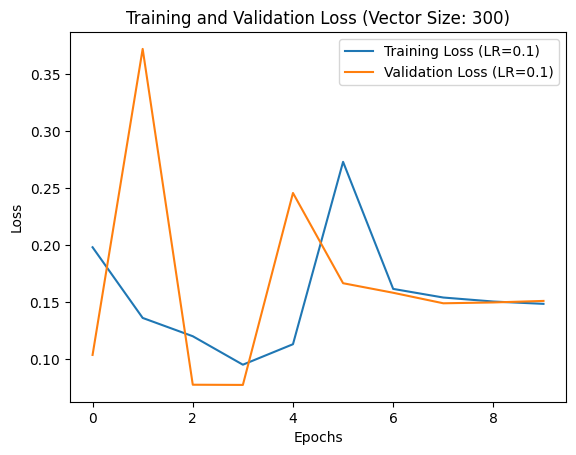

55/55 [==============================] - 0s 2ms/step
Classification Report (Vector Size: 300):
                 precision    recall  f1-score   support

Defense Evasion       1.00      0.00      0.00       143
      Discovery       0.99      1.00      1.00      1745
      Execution       0.69      0.91      0.78       701
       Harmless       1.00      0.00      0.00        21
         Impact       1.00      0.00      0.00         5
          Other       1.00      0.00      0.00         5
    Persistence       0.90      1.00      0.95      1586

      micro avg       0.90      0.94      0.92      4206
      macro avg       0.94      0.42      0.39      4206
   weighted avg       0.91      0.94      0.90      4206
    samples avg       0.91      0.94      0.92      4206

129/129 [==============================] - 0s 1ms/step
Classification Report on Train Set (Vector Size: 300):
                 precision    recall  f1-score   support

Defense Evasion       1.00      0.00      0.00    

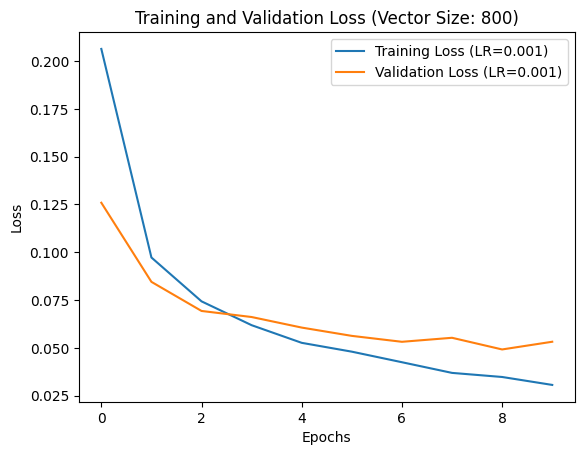

55/55 [==============================] - 0s 3ms/step
Classification Report (Vector Size: 800):
                 precision    recall  f1-score   support

Defense Evasion       0.90      0.86      0.88       143
      Discovery       1.00      1.00      1.00      1745
      Execution       0.85      0.96      0.90       701
       Harmless       0.50      0.24      0.32        21
         Impact       0.50      0.40      0.44         5
          Other       1.00      0.00      0.00         5
    Persistence       0.99      0.99      0.99      1586

      micro avg       0.96      0.98      0.97      4206
      macro avg       0.82      0.64      0.65      4206
   weighted avg       0.96      0.98      0.97      4206
    samples avg       0.96      0.98      0.97      4206

129/129 [==============================] - 0s 2ms/step
Classification Report on Train Set (Vector Size: 800):
                 precision    recall  f1-score   support

Defense Evasion       0.97      0.93      0.95    

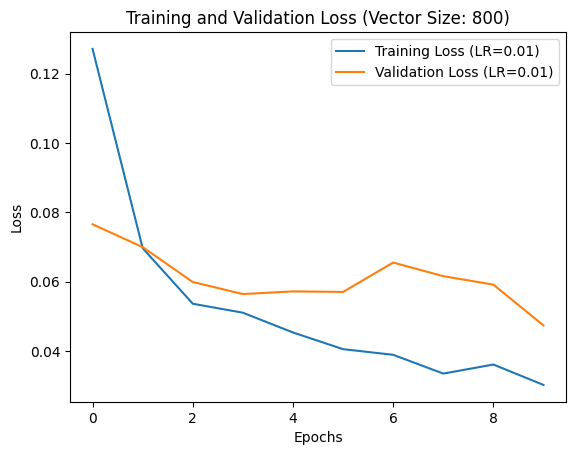

55/55 [==============================] - 0s 2ms/step
Classification Report (Vector Size: 800):
                 precision    recall  f1-score   support

Defense Evasion       0.84      0.90      0.87       143
      Discovery       1.00      1.00      1.00      1745
      Execution       0.89      0.94      0.92       701
       Harmless       0.62      0.38      0.47        21
         Impact       1.00      0.00      0.00         5
          Other       0.50      0.20      0.29         5
    Persistence       1.00      0.98      0.99      1586

      micro avg       0.97      0.98      0.97      4206
      macro avg       0.84      0.63      0.65      4206
   weighted avg       0.97      0.98      0.97      4206
    samples avg       0.97      0.98      0.97      4206

129/129 [==============================] - 0s 2ms/step
Classification Report on Train Set (Vector Size: 800):
                 precision    recall  f1-score   support

Defense Evasion       0.96      0.94      0.95    

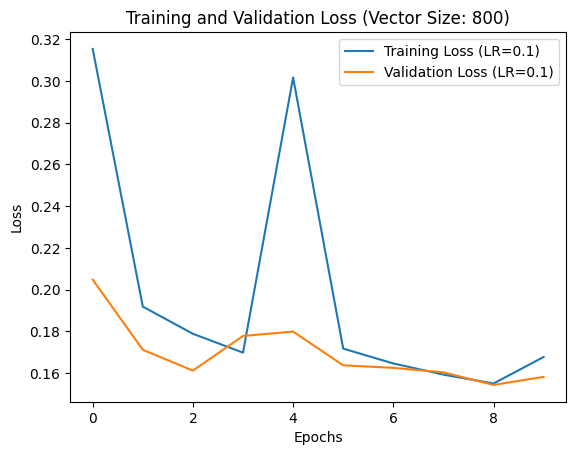

55/55 [==============================] - 0s 2ms/step
Classification Report (Vector Size: 800):
                 precision    recall  f1-score   support

Defense Evasion       0.56      0.83      0.67       143
      Discovery       0.99      1.00      1.00      1745
      Execution       0.53      0.79      0.63       701
       Harmless       1.00      0.00      0.00        21
         Impact       1.00      0.00      0.00         5
          Other       1.00      0.00      0.00         5
    Persistence       0.98      0.95      0.97      1586

      micro avg       0.86      0.93      0.90      4206
      macro avg       0.87      0.51      0.47      4206
   weighted avg       0.90      0.93      0.91      4206
    samples avg       0.87      0.94      0.90      4206

129/129 [==============================] - 0s 2ms/step
Classification Report on Train Set (Vector Size: 800):
                 precision    recall  f1-score   support

Defense Evasion       0.60      0.87      0.71    

In [18]:
# Loop over each vector size
for vector_size in vector_sizes:
    X, y, doc2vec_model = train_doc2vec_model(df_sampled, vector_size, epochs=10)
    X_train, X_test, y_train, y_test = split_train_test(X, y, train_size=train_size, random_state=random_state)

    # Loop over each learning rate
    for learning_rate in learning_rates:
        train_and_evaluate(X_train, X_test, y_train, y_test, vector_size, learning_rate, epochs)

# FINE TEST

In [52]:
'''sns.set_theme(style="darkgrid")
for result in results:
    plt.figure(figsize=(12, 6))

    print(result.get("metrics").history)
    plt.suptitle(f"learning rate: {result.get('learning_rate')}")

    plt.subplot(2, 2, 1)
    plt.plot(result.get("metrics").history["loss"], label='Training Loss')
    plt.plot(result.get("metrics").history["val_loss"], label='Validation Loss')
    plt.title("Training and Validation Loss")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(result.get("metrics").history["auc"], label="Training AUC")
    plt.plot(result.get("metrics").history["val_auc"], label="Validation AUC")
    plt.title("Training and Validation AUC")
    plt.ylabel("AUC")
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(result.get("metrics").history["precision"], label="Training Precision")
    plt.plot(result.get("metrics").history["val_precision"], label="Validation Precision")
    plt.title("Training and Validation Precision")
    plt.ylabel("Precision")
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(result.get("metrics").history["recall"], label="Training Recall")
    plt.plot(result.get("metrics").history["val_recall"], label="Validation Recall")
    plt.title("Training and Validation Recall")
    plt.ylabel("Recall")
    plt.legend()


    plt.tight_layout()
    plt.show()'''

'sns.set_theme(style="darkgrid")\nfor result in results:\n    plt.figure(figsize=(12, 6))\n\n    print(result.get("metrics").history)\n    plt.suptitle(f"learning rate: {result.get(\'learning_rate\')}")\n\n    plt.subplot(2, 2, 1)\n    plt.plot(result.get("metrics").history["loss"], label=\'Training Loss\')\n    plt.plot(result.get("metrics").history["val_loss"], label=\'Validation Loss\')\n    plt.title("Training and Validation Loss")\n    plt.ylabel("Loss")\n    plt.legend()\n\n    plt.subplot(2, 2, 2)\n    plt.plot(result.get("metrics").history["auc"], label="Training AUC")\n    plt.plot(result.get("metrics").history["val_auc"], label="Validation AUC")\n    plt.title("Training and Validation AUC")\n    plt.ylabel("AUC")\n    plt.legend()\n\n    plt.subplot(2, 2, 3)\n    plt.plot(result.get("metrics").history["precision"], label="Training Precision")\n    plt.plot(result.get("metrics").history["val_precision"], label="Validation Precision")\n    plt.title("Training and Validation Pre

Results for Learning Rate: 0.1, Epochs: 5
Training Metrics:
The initial 5 epochs show significant improvements in various metrics. The loss decreases, and AUC, precision, and recall all exhibit positive trends. These improvements indicate that the model is learning from the data and adapting its parameters to better fit the training set.

Validation Metrics:
Validation metrics also show promising results after 5 epochs. The decreasing validation loss and improving AUC, precision, and recall suggest that the model generalizes well to unseen data.

Results for Learning Rate: 0.1, Epochs: 10
Training Metrics:
Extending training to 10 epochs results in continued improvements, albeit at a slower rate. The loss, AUC, precision, and recall all show positive trajectories, indicating ongoing refinement of the model.

Validation Metrics:
Validation metrics maintain consistency with training metrics, showcasing that the model's performance extends beyond the training set. The decreasing validation loss and improvements in AUC, precision, and recall suggest that the model is still benefiting from additional training.

Results for Learning Rate: 0.1, Epochs: 15
Training Metrics:
Training for 15 epochs demonstrates marginal improvements in metrics. The loss continues to decrease, but AUC, precision, and recall show slower rates of improvement, indicating potential diminishing returns.

Validation Metrics:
Validation metrics exhibit similar trends, with diminishing returns after 10 epochs. While the model continues to generalize, the rate of improvement decreases.

Discussion on Sufficient Epochs:
The observed trends suggest that the model achieves significant gains within the initial 5 to 10 epochs. Beyond this point, the rate of improvement diminishes, indicating that additional epochs may offer limited benefits. This phenomenon is often referred to as "early stopping," where training is halted once the model's performance plateaus, preventing overfitting.

Considering computational efficiency and avoiding overfitting, it seems reasonable to stop training around 10 epochs. This allows the model to capture the underlying patterns in the data without unnecessary computational costs.

6 Epochs: Stopping at 6 epochs appears to capture substantial improvements in the model. The trends indicate that the model is learning effectively, and additional epochs may provide diminishing returns.

10 Epochs: Extending training to 10 epochs could lead to further refinement, particularly in fine-tuning the model's parameters. However, this comes with increased computational cost.

Stopping at 6 epochs seems to strike a balance between efficiency and model performance

Comparison with Learning Rate: 0.1
Learning Rate: 0.01 vs. 0.1
Loss: The model with a learning rate of 0.01 generally achieves lower training and validation losses, indicating better convergence.
AUC: Both learning rates show similar positive trends in AUC, but 0.01 may provide slightly better discrimination ability.
Precision and Recall: Both learning rates lead to improved precision and recall, but 0.01 appears to offer slightly better performance.

The learning rate of 0.001 demonstrates effective learning, showing superior convergence and performance across key metrics compared to 0.01 and 0.1.
While both 0.01 and 0.1 show reasonable performance, 0.001 is a promising candidate for further experimentation and fine-tuning to optimize model performance.